# Virginia Genomics Center of Excellence

In [ ]:
# correlate deaths and cases by state
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

In [ ]:
# Create rolling average changes
# pivot wider
# this will also be needed when we create lags
us_states <- us_states_long %>%
  # discard dates before cases were tracked.
  filter(date > as.Date("2020-03-01")) %>%
  pivot_wider(names_from = "data_type", values_from = "value") %>%
  rename(state = location) %>%
  select(date, state, cases_total, deaths_total) %>%
  mutate(state = as_factor(state)) %>%
  arrange(state, date) %>%
  group_by(state) %>%
  # smooth the data with 7 day moving average
  mutate(cases_7day = (cases_total - lag(cases_total, 7)) / 7) %>%
  mutate(deaths_7day = (deaths_total - lag(deaths_total, 7)) / 7)

# national analysis
# ----------------------------------------------
# aggregate state to national
us <- us_states %>%
  group_by(date) %>%
  summarize(across(
    .cols = where(is.double),
    .fns = function(x) sum(x, na.rm = T),
    .names = "{col}"
  ))

# create columns for deaths led 0 to 40 days ahead
max_lead <- 40
us_lags <- us %>%
  # create lags by day
  tk_augment_lags(deaths_7day, .lags = 0:-max_lead, .names = "auto")
# fix names to remove minus sign
names(us_lags) <- names(us_lags) %>% str_replace_all("lag-|lag", "lead")

# use only case dates where we have complete future knowledge of deaths for all lead times.
us_lags <- us_lags %>% filter(date < cutoff_end - max_lead)

In [ ]:
# make long form to nest
# initialize models data frame
models <- us_lags %>%
  ungroup() %>%
  pivot_longer(
    cols = contains("lead"),
    names_to = "lead",
    values_to = "led_deaths"
  ) %>%
  select(date, cases_7day, lead, led_deaths) %>%
  mutate(lead = as.numeric(str_remove(lead, "deaths_7day_lead"))) %>%
  nest(data = c(date, cases_7day, led_deaths)) %>%
  # Run a regression on lagged cases and date vs deaths
  mutate(model = map(
    data,
    function(df) {
      lm(led_deaths ~ cases_7day + poly(as.numeric(as.Date(date)), 2), data = df)
    }
  ))

# Add regression coefficient
# get adjusted r squared
models <- models %>%
  mutate(adj_r = map(model, function(x) {
    glance(x) %>%
      pull(adj.r.squared)
  })
  %>% unlist())
print(models)

# A tibble: 41 × 4
    lead data               model  adj_r
   <dbl> <list>             <list> <dbl>
 1     0 <tibble [218 × 3]> <lm>   0.164
 2     1 <tibble [218 × 3]> <lm>   0.187
 3     2 <tibble [218 × 3]> <lm>   0.212
 4     3 <tibble [218 × 3]> <lm>   0.241
 5     4 <tibble [218 × 3]> <lm>   0.272
 6     5 <tibble [218 × 3]> <lm>   0.307
 7     6 <tibble [218 × 3]> <lm>   0.343
 8     7 <tibble [218 × 3]> <lm>   0.383
 9     8 <tibble [218 × 3]> <lm>   0.424
10     9 <tibble [218 × 3]> <lm>   0.467
# ℹ 31 more rows

# Model Fit

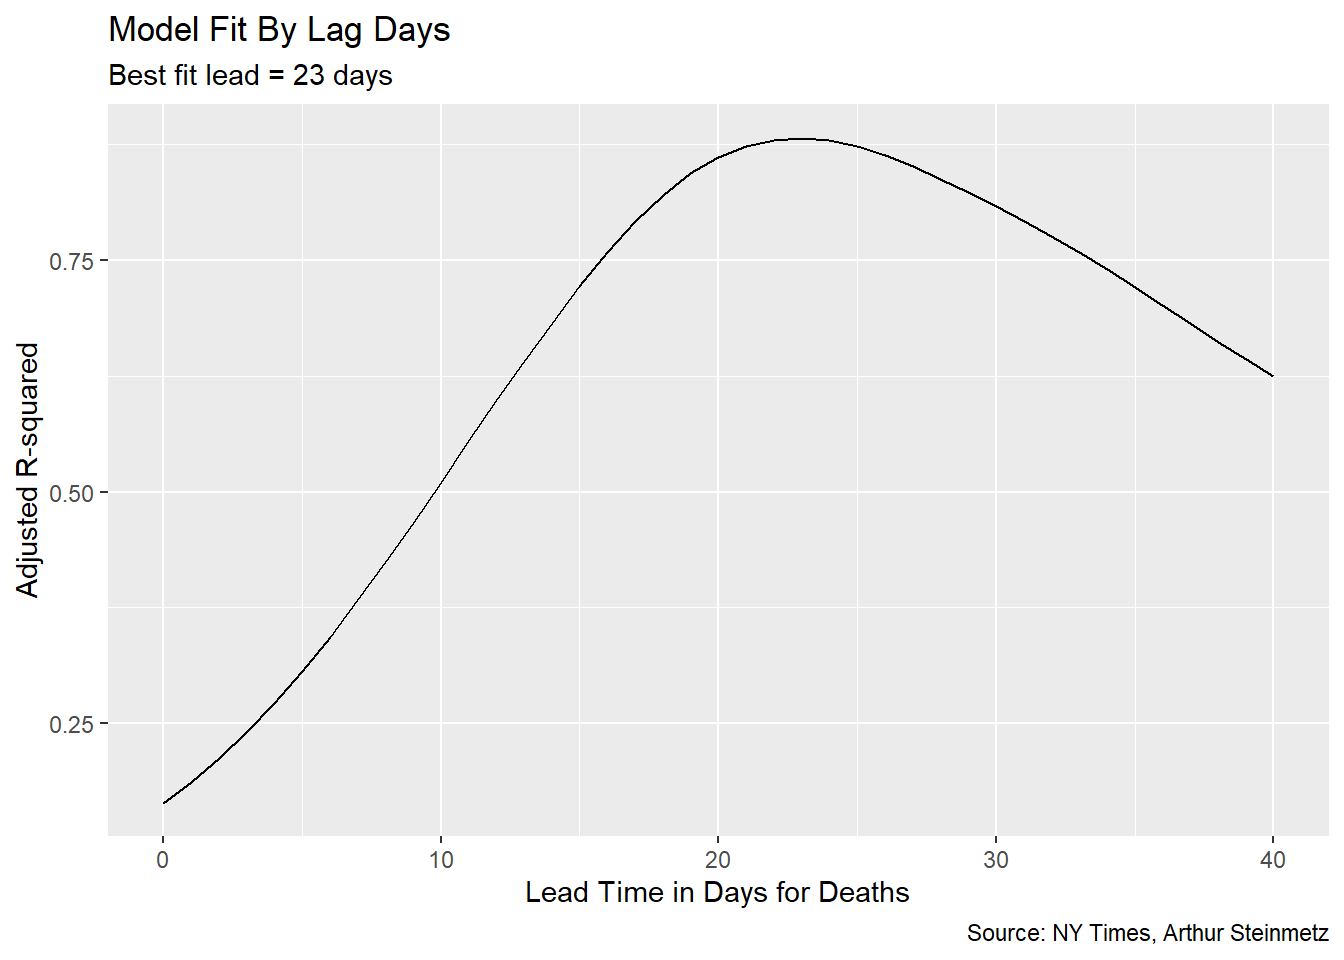

In [ ]:
# Show model fit by lead time
# make predictions using best model
best_fit <- models %>%
  summarize(adj_r = max(adj_r)) %>%
  left_join(models, by = "adj_r")

g <- models %>%
  ggplot(aes(lead, adj_r)) +
  geom_line() +
  labs(
    subtitle = paste("Best fit lead =", best_fit$lead, "days"),
    title = "Model Fit By Lag Days",
    x = "Lead Time in Days for Deaths",
    caption = "Source: NY Times, Arthur Steinmetz",
    y = "Adjusted R-squared"
  )
show(g)

# Main Plot

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'

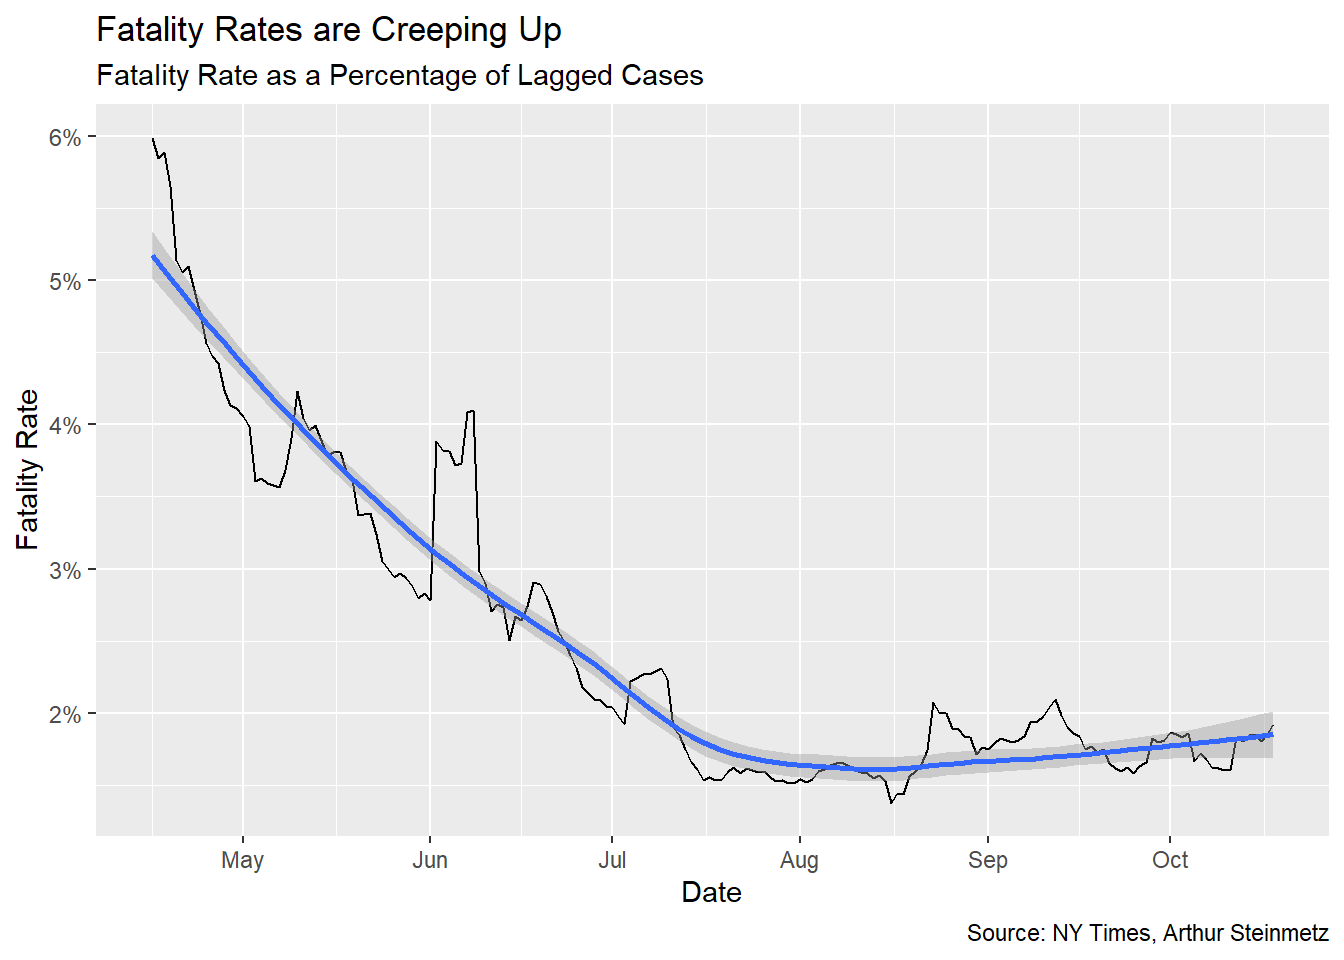

In [ ]:
#| warning: false
#| message: false
#| label: fig-fatality-plot
#| fig-cap: "COVID-19 fatalities, outputs from New York Times modeling."

fatality <- best_fit$data[[1]] %>%
  filter(cases_7day > 0) %>%
  filter(date > as.Date("2020-04-15")) %>%
  mutate(rate = led_deaths / cases_7day)

g <- fatality %>% ggplot(aes(date, rate)) +
  geom_line() +
  geom_smooth() +
  labs(
    x = "Date", y = "Fatality Rate",
    title = "Fatality Rates are Creeping Up",
    subtitle = "Fatality Rate as a Percentage of Lagged Cases",
    caption = "Source: NY Times, Arthur Steinmetz"
  ) +
  scale_y_continuous(labels = scales::percent)
show(g)